In [1]:
import sys
sys.path.append('..')

import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.layers import *
import pandas as pd
import numpy as np
from position import Position
import matplotlib.pyplot as plt
%matplotlib inline
import imp
# imp.reload(cnnfeat)
from multiprocessing import Queue
from multiprocessing import Manager, Process, Pool
import os
from time import time
import pickle
import bcolz
from tqdm import tqdm 
from cnnfeat import get_feats
import numpy as np

Using TensorFlow backend.


Initializing Magics


In [2]:
from tools.cycliclr import CyclicLR
from math import ceil

In [47]:
def dense_block(x, filters, nb_layers):
    layers = [x]
    for i in range(nb_layers):
        x = conv_block(x, filters, bottleneck=(i>=2))
        layers.append(x)
        x = Concatenate(axis=-1)(layers)
    return x

In [200]:
def conv_block(x, filters, kernel_size=(2,2), bottleneck=False, **kwargs):
    if bottleneck:
        x = Convolution2D(filters * 2, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False)(x)
    x = Convolution2D(filters, kernel_size, strides=(1,1), padding='same', use_bias=False#)(x)
                      ,kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    return x

In [201]:
def dense_model():
    net_input = Input((8,8,14), name='feats_input')
    x = Dense(64, name='dense1')(net_input)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu', name='dense1_act')(x)
    x = Dropout(.5)(x)
    
    x = Dense(32, name='dense2')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu', name='dense2_act')(x)
    x = Dropout(.5)(x)
    
    val = GlobalAveragePooling2D(name='value_hidden1')(x)
    val = Dense(1, name='value_hidden')(val) #, kernel_regularizer=regularizers.l2(1e-4)
    val = Activation('tanh', name='value_tanh')(val)
    
    #pol = conv_block(x, 128)
    pol = Flatten(name='flatten')(x)
    pol = Dense(8*8*11*8, name='pol_hidden')(pol)
    pol = Activation('softmax', name='pol_softmax')(pol)

    return net_input, val, pol

In [246]:
# experimental
def dense_model():
    net_input = Input((8,8,14), name='feats_input')
    
    x = net_input
    x = dense_block(x, 192, 3)

    val = Convolution2D(1, (2,2), strides=(1,1), padding='same', use_bias=False, name='final1')(x)
    val = GlobalAveragePooling2D()(val)
    val = Activation('tanh', name='value_tanh')(val)
    
    pol = Dense(32, name='dense2')(x) # on filters!
    pol = BatchNormalization(axis=-1)(pol)
    pol = Activation('relu', name='dense2_act')(pol)   
    # Similar performance instead of Dense/BN/ReLU
    # pol = Convolution2D(32, (2,2), strides=(1,1), padding='same', use_bias=False, name='final2')(x)

    pol = Flatten(name='flatten')(pol)
    pol = Dense(8*8*11*8, name='pol_hidden')(pol)
    pol = Activation('softmax', name='pol_softmax')(pol)

    return net_input, val, pol

In [247]:
inputs, val_out, pol_out = dense_model()
model = Model(inputs, [val_out, pol_out])

In [248]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feats_input (InputLayer)        (None, 8, 8, 14)     0                                            
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 8, 8, 192)    10752       feats_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_176 (BatchN (None, 8, 8, 192)    768         conv2d_196[0][0]                 
__________________________________________________________________________________________________
activation_158 (Activation)     (None, 8, 8, 192)    0           batch_normalization_176[0][0]    
__________________________________________________________________________________________________
concatenat

In [7]:
def san_to_label(san_move):
    """ Return index into 8*8*11*8 possibilities of from_sq (row*col) to to_sq (row*col).
    3 rows are added for underpromotions. """
    # g5 => row 5, col 7(g) => (4, 6)
    # h6 => row 6, col 8(h) => (5, 7) 
    from_coord = [int(san_move[1:2]) - 1, ord(san_move[0:1]) - 97]
    to_coord = [int(san_move[3:4]) - 1, ord(san_move[2:3]) - 97]
    if len(san_move) == 5:
        if san_move[4:5] == 'n': to_coord[0] += 1
        elif san_move[4:5] == 'b': to_coord[0] += 2
        elif san_move[4:5] == 'r': to_coord[0] += 3
    return np.ravel_multi_index(from_coord + to_coord, (8,8,11,8), order='C')

def sans_to_labels(san_moves):
    return list(map(san_to_label, san_moves))

In [8]:
def label_to_san(label):
    coords = np.unravel_index(label, (8,8,11,8))
    from_sq, to_sq = coords[0:2], coords[2:4]
    return coord_to_san(from_sq) + coord_to_san(to_sq)
    
def coord_to_san(coord):
    y, x = coord
    promo = ''
    if y >= 7:
        pt = y - 7
        y = 7
        if pt == 0: promo = ''
        elif pt == 1: promo = 'n'
        elif pt == 2: promo = 'b'
        elif pt == 3: promo = 'r'
    return chr(x+97) + str(y+1) + promo

label_to_san(san_to_label('e3g4'))

'e3g4'

In [9]:
def batch_generator_df_bcolz(dframe, bcolz_arr, batch_size, shuffle=True, yielder=lambda x: x):
    assert(batch_size % bcolz_arr.chunklen == 0)
    chunks_per_batch = batch_size // bcolz_arr.chunklen
    init_bounds = bcolz_arr.partitions
    if bcolz_arr.leftover_elements > 0:
        init_bounds.append((init_bounds[-1][1], len(bcolz_arr)))
    while True:
        bounds = np.random.permutation(init_bounds) if shuffle else init_bounds
        # feats_chunks, scores_chunks = [], []
        feats_chunks, move_chunks, score_chunks = [], [], []
        def return_batch():
            feats = np.concatenate(feats_chunks, axis=0)
            moves = np.concatenate(move_chunks, axis=0)
            scores = np.concatenate(score_chunks, axis=0)
            feats_chunks.clear()
            move_chunks.clear()
            score_chunks.clear()
            return yielder((feats, [scores, moves]))
        chunks = 0
        for start, stop in bounds:
            feats_chunks.append(bcolz_arr[start:stop])
            moves = np.array(dframe[start:stop].move)
            move_chunks.append(sans_to_labels(moves))
            score_chunks.append(np.array(dframe[start:stop].score, dtype='float32'))
            chunks += 1
            if chunks % chunks_per_batch == 0:
                yield return_batch()
        if len(feats_chunks) > 0:
            yield return_batch()

In [7]:
from bcolz_array_iterator import BcolzArrayIterator

def batch_generator_bcolz(data, batch_size, shuffle=True):
    batch_generator_bcolz = BcolzArrayIterator(data, batch_size=batch_size, shuffle=shuffle)
    while True:
        feats = next(batch_generator_bcolz)
        yield feats, feats

In [8]:
def batch_generator_df(data, batch_size, shuffle=True):
    while True:
        data_ = data.sample(frac=1) if shuffle else data
        for iteration, batch in data_.groupby(np.arange(len(data)) // batch_size):
            fens = [f.strip() for f in batch.fen.tolist()]
            feats = np.stack([get_feats(Position.from_fen(fen)) for fen in fens])
            yield feats, feats

In [150]:
# model.compile(keras.optimizers.SGD(lr=.01, momentum=.99, nesterov=True), 'mse')

In [11]:
features = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_move_scores_sf4_origfen.bc')
features_valid = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_move_scores_sf4_origfen_valid.bc')

In [12]:
move_scores = pd.read_pickle('/ssd/slonik_data/sf_move_scores_4dep.pkl')

In [13]:
#move_scores.to_pickle('/ssd/slonik_data/sf_move_scores_4dep.pkl')

In [14]:
def get_feats_stack(fens):
    return np.stack([get_feats(Position.from_fen(f)) for f in fens])

In [15]:
assert(np.allclose(features_valid[0], get_feats(Position.from_fen(move_scores.iloc[-60000].orig_fen))))
assert(np.allclose(features_valid[0:100], get_feats_stack(move_scores.iloc[-60000:-60000+100].orig_fen)))
assert(np.allclose(features[0], get_feats(Position.from_fen(move_scores.iloc[0].orig_fen))))
assert(np.allclose(features[23470:23570], get_feats_stack(move_scores.iloc[23470:23570].orig_fen)))

In [16]:
wgts = model.get_weights()

In [146]:
model.set_weights(wgts)

In [249]:
model.compile('adam', 
              loss=['mse', 'sparse_categorical_crossentropy'], 
#               loss_weights=[1.0/4.0, 1.0])
               loss_weights=[1.0, 1.0/50])

In [250]:
batch_size = 64
#nvalid = len(features_sf12_valid)

x = features
x_valid = features_valid

# yielder = lambda f_s: (f_s[0], [f_s[0], f_s[1]]) # (feats, [feats, scores])
train_gen = batch_generator_df_bcolz(move_scores[:-60000], x, batch_size)
valid_gen = batch_generator_df_bcolz(move_scores[-60000:], x_valid, batch_size, shuffle=False)

train_steps = ceil(len(x) / batch_size / 50.0)
valid_steps = ceil(len(x_valid) / batch_size / 50.0)

lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
# checkpoint_path = '../slonik_data/weights.{epoch:03d}-{val_loss:.6f}.h5'
checkpoint_path = '../../slonik_data/weights_best.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             monitor='val_loss', save_best_only=True, save_weights_only=True, period=1)
stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')

# clr = CyclicLR(base_lr=1e-4, max_lr=3.75e-3, step_size=train_steps*4, mode='triangular')

# clr = CyclicLR(base_lr=1e-8, max_lr=2e-2, step_size=train_steps*10, mode='triangular')

K.set_value(model.optimizer.lr, 2e-4)
#K.set_value(model.optimizer.lr, 1e-5)

# callbacks = [clr]
# callbacks = [clr, checkpoint]
callbacks = [checkpoint, stopping, lr_plateau]

hist = model.fit_generator(train_gen, train_steps, epochs=30, 
                          validation_data=valid_gen, validation_steps=valid_steps
                          , callbacks=callbacks
                   )
hist
# K.set_value(model.optimizer.lr, 1e-4)
# model.fit_generator(train_gen, train_steps, epochs=2, validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/30
198/198 [==============================] - 10s 50ms/step - loss: 0.1925 - value_tanh_loss: 0.0572 - pol_softmax_loss: 6.5202 - val_loss: 0.2484 - val_value_tanh_loss: 0.1024 - val_pol_softmax_loss: 7.0578
Epoch 2/30
198/198 [==============================] - 5s 24ms/step - loss: 0.1677 - value_tanh_loss: 0.0483 - pol_softmax_loss: 5.7270 - val_loss: 0.1905 - val_value_tanh_loss: 0.0617 - val_pol_softmax_loss: 6.1997
Epoch 3/30
198/198 [==============================] - 5s 24ms/step - loss: 0.1573 - value_tanh_loss: 0.0454 - pol_softmax_loss: 5.3533 - val_loss: 0.1661 - val_value_tanh_loss: 0.0567 - val_pol_softmax_loss: 5.2285
Epoch 4/30
198/198 [==============================] - 5s 24ms/step - loss: 0.1489 - value_tanh_loss: 0.0424 - pol_softmax_loss: 5.0842 - val_loss: 0.1656 - val_value_tanh_loss: 0.0630 - val_pol_softmax_loss: 4.8927
Epoch 5/30
198/198 [==============================] - 5s 24ms/step - loss: 0.1398 - value_tanh_loss: 0.0418 - pol_softmax_loss: 4.6606 - va

In [212]:
K.get_value(model.optimizer.lr)

2.9296877e-12

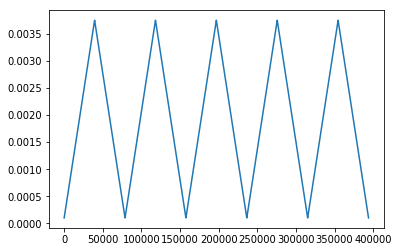

In [163]:
plt.plot(clr.history['iterations'], clr.history['lr'])

In [121]:
clr.history.keys()

dict_keys(['lr', 'iterations', 'batch', 'size', 'loss', 'val_tanh_loss', 'pol_softmax_loss'])

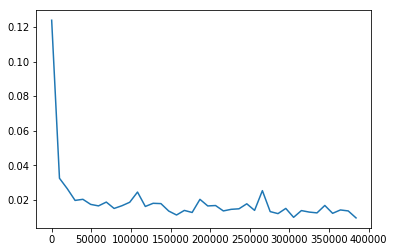

In [164]:
rng = np.s_[::train_steps]
plt.plot(clr.history['iterations'][rng], clr.history['loss'][rng])

In [137]:
hist.history.keys()

dict_keys(['val_loss', 'val_val_tanh_loss', 'val_pol_softmax_loss', 'loss', 'val_tanh_loss', 'pol_softmax_loss'])

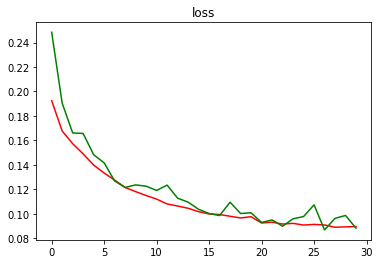

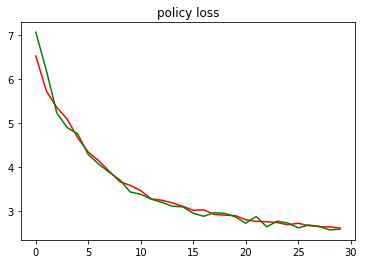

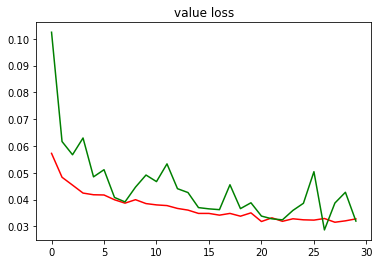

In [251]:
h = hist.history
rng = np.s_[::]
x = np.arange(len(h['loss']))
plt.title('loss')
plt.plot(x[rng], h['loss'][rng], 'r', 
         x[rng], h['val_loss'][rng], 'g'
        )
plt.show()
plt.title('policy loss')
plt.plot(x[rng], h['pol_softmax_loss'][rng], 'r', 
         x[rng], h['val_pol_softmax_loss'][rng], 'g'
        )
plt.show()
plt.title('value loss')
plt.plot(x[rng], h['value_tanh_loss'][rng], 'r', 
         x[rng], h['val_value_tanh_loss'][rng], 'g'
        )
plt.show()

### evaluate models

In [117]:
.032 / np.array(move_scores.score, dtype='float32').std()

0.10860244345474007

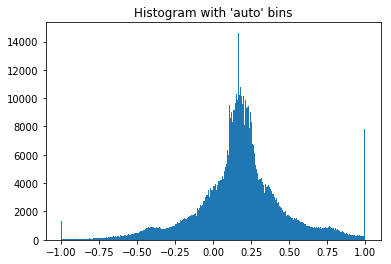

In [17]:
plt.hist(np.array(move_scores.score, dtype='float32'), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [252]:
batch_size = 64
valid_steps = ceil(len(features_valid) / batch_size)
valid_gen = batch_generator_df_bcolz(move_scores[-60000:], features_valid, batch_size, shuffle=False)
print(model.metrics_names)
model.evaluate_generator(valid_gen, steps=valid_steps)
# train_model.metrics_names
# K.get_value(train_model.optimizer.lr)
# [0.012734119832019011, 0.0044044992691526811, 2.498886107635498]
# [0.10248853038946787, 0.048560829406976702, 2.6963851141611737]
# [0.087685947628815972, 0.031499455111225448, 2.5938048179626465]

['loss', 'value_tanh_loss', 'pol_softmax_loss']


[0.090058952530225111, 0.033633665759364766, 2.6021516637166342]

In [202]:
model.save_weights('../../slonik_data/weights_best_mlp0_value_policy.h5')

In [210]:
model.load_weights('../../slonik_data/weights_best_mlp0_value_policy.h5')

In [208]:
model.load_weights('../../slonik_data/weights_best.h5')

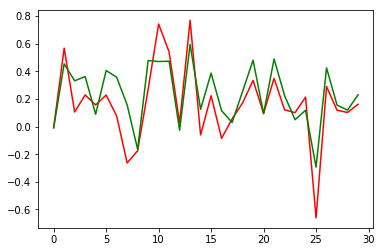

In [253]:
rng = slice(220,250)
dfrng = slice(rng.start+-60000, rng.stop+-60000)
fens = move_scores[dfrng].orig_fen
scores = move_scores[dfrng].score
# np.allclose(features_sf12_valid[rng], np.array([get_feats(Position.from_fen(f)) for f in fens]))
# pprint(list(zip(scores, evaluator.predict(features_sf12_valid[rng]).squeeze())))
x = np.arange(len(scores))
plt.plot(x, scores, 'r')
plt.plot(x, model.predict(features_valid[rng])[0].squeeze(), 'g')

In [254]:
n = 155
print(Position.from_fen(move_scores.iloc[-60000+n].orig_fen))
print(move_scores.iloc[-60000+n].move)
preds = model.predict(features_valid[n][None])[1][0]
label_to_san(np.argmax(preds))
topk = np.argpartition(preds, -5)[-5:]
topk_sorted = topk[np.argsort(preds[topk])][::-1]
topk_sorted
[label_to_san(k) for k in topk_sorted]

B to move
 ·  ·  ·  ·  ·  ·  ·  · 
 ♟  ♟  ·  ·  ·  ·  ·  · 
 ·  ·  ♝  ·  ·  ·  ·  ♟ 
 ♙  ·  ♚  ♟  ·  ·  ♜  · 
 ·  ·  ♟  ·  ·  ♖  ·  · 
 ·  ·  ♞  ·  ·  ♙  ·  · 
 ·  ·  ♙  ·  ·  ♔  ·  ♘ 
 ·  ·  ·  ·  ♖  ·  ·  · 

c6a4


['g5f5', 'd5d4', 'g5c5', 'c3d1', 'g5g4']